# Getting the Data 
Google Colab has been used through out the lab work.

In [ ]:
import io
import pandas as pd
import numpy as np
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['spam.csv']), encoding='latin-1')
print(df.head(20).to_string())

      v1                                                                                                                                                                                                    v2 Unnamed: 2 Unnamed: 3 Unnamed: 4
0    ham                                                                                Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... until         NaN        NaN        NaN
1    ham                                                                                                                                                                         Ok lar... Joking wif u oni...        NaN        NaN        NaN
2   spam                                           Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's        NaN        NaN        NaN
3    ham                                

# Data Cleaning
Note that as per the notebook instructions, I have NOT filtered common words or words with maximum/minimum frequencies.

In [ ]:
def remove_punctuation(x): #method to remove punctuation
  try:
    x = x.str.replace('[^\w\s]','')
  except:
    pass
  return x
clean = df.apply(remove_punctuation)
#clean.head(10)
clean = clean.loc[:, ~clean.columns.str.contains('^Unnamed')] #Removing the unnamed columns
clean.columns = ['Category','Message'] #Renaming Columns for convinience
clean['Message'] = clean['Message'].map(str.lower) #Changing all string to lower case
print(clean.head(10).to_string())

  Category                                                                                                                                                     Message
0      ham                                               go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat until 
1      ham                                                                                                                                     ok lar joking wif u oni
2     spam       free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s
3      ham                                                                                                                 u dun say so early hor u c already then say
4      ham                                                                                                 nah i dont think he goes to usf he lives around here thoug

<ipython-input-30-9d74de35f562>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  x = x.str.replace('[^\w\s]','')


# Splitting the Data

In [ ]:
train_data = clean.sample(frac = 0.75)
test_data = clean.drop(train_data.index)
print(train_data.shape[0]) #Number of rows in training dataset
print(test_data.shape[0])  #Number of rows in testing dataset
print(train_data.shape[0]/clean.shape[0]) #Ratio of Data put into training set
print(test_data.shape[0]/clean.shape[0]) #Ratio of Data put into testing set

4179
1393
0.75
0.25


# Making a Word Frequency DataFrame

In [ ]:
train_wordbag =' '.join(train_data.Message).split(' ') #Putting all words into a list
train_wordbag = list(dict.fromkeys(train_wordbag)) #Dictionary keys are unique so this eliminates repeatation of words. 
#Separating spam words and ham words into separate categories
train_spamlist = ' '.join(train_data[train_data.Category == 'spam'].Message).split(' ') 
train_hamlist = ' '.join(train_data[train_data.Category == 'ham'].Message).split(' ')
#These lists will contain frequency of each word
spam_f = []
ham_f = []
word_freq = pd.DataFrame()
#Loop to get how many times each word in the bag appeared in their respective categories
for w in train_wordbag:
    spam_f.append(train_spamlist.count(w))
    ham_f.append(train_hamlist.count(w))
word_freq['Word'] = train_wordbag
word_freq['#Spam'] = spam_f
word_freq['#Ham'] = ham_f
print(word_freq.head(10).to_string())

            Word  #Spam  #Ham
0           good      9   178
1            job      0    32
2              i     34  1609
3           like      7   173
4  entrepreneurs      0     1
5            pls      7    75
6           tell     12    91
7         nelson      0     1
8           that     22   359
9            the    149   872


# Visualising the Data

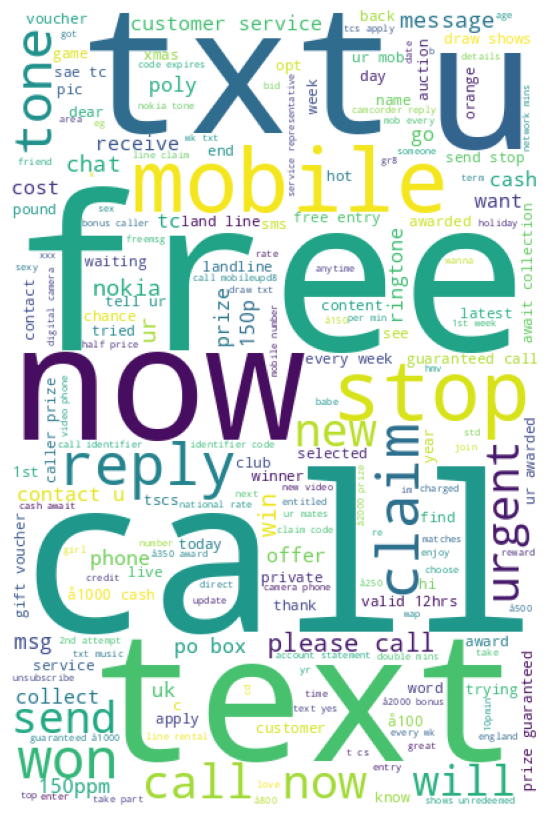

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

text = ' '.join(train_data[train_data.Category == 'spam'].Message)
stopwords = STOPWORDS #Common english words to be ignored
wc = WordCloud(background_color='white', stopwords = stopwords, height = 600, width = 400).generate(text)

plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Making a probability Table 

In [ ]:
word_prob = pd.DataFrame() #new dataframe for probabilities
ham_count = (train_data['Category']=='ham').sum()
spam_count = (train_data['Category']=='spam').sum()
k = 0.5 #Pseudocount as suggested
word_prob['Word'] = word_freq['Word']
word_prob['Prob_Spam'] = (word_freq['#Spam']+k)/(spam_count+2*k) #This is actually P(E|S)
word_prob['Prob_Ham'] = (word_freq['#Ham']+k)/(ham_count+2*k) #This is actually P(E|'S)
print(word_prob.head(10).to_string())

            Word  Prob_Spam  Prob_Ham
0           good   0.017210  0.049187
1            job   0.000906  0.008956
2              i   0.062500  0.443511
3           like   0.013587  0.047809
4  entrepreneurs   0.000906  0.000413
5            pls   0.013587  0.020805
6           tell   0.022645  0.025214
7         nelson   0.000906  0.000413
8           that   0.040761  0.099063
9            the   0.270833  0.240424


# Checking "Spamliness"
Note that I have included the correction of floating point underflow in the following method. Also tests for a single word and a bunch of words have been included under the section "Preliminary Tests".

In [ ]:
#We set the priors equal to their respective proportions
ham_prob = ham_count/(ham_count+spam_count) 
spam_prob = spam_count/(ham_count+spam_count)

def spamliness(sent, vision = False): #Method to check Spamliness
  valid_set = [w for w in sent if w in train_wordbag]
  #These extract the relevant probabilities from the probability table
  sw_prob = [] 
  hw_prob = []
  for i in valid_set:
     #Getting the probabilities of relevant words being ham/spam and storing it.
     sw_prob.append(word_prob[word_prob['Word']==i]['Prob_Spam'].item())
     hw_prob.append(word_prob[word_prob['Word']==i]['Prob_Ham'].item())
  #Logs to avoid floating point underflow
  spam_total = sum(np.log(k) for k in sw_prob) + np.log(spam_prob) #Calculating the total for spam
  ham_total = sum(np.log(k) for k in hw_prob) + np.log(ham_prob) #Calculating the total for ham
  if vision == True: #Enables the users to see details
    data = pd.DataFrame()
    data['Word'] = valid_set
    data['P(E|S)'] = sw_prob
    data['P(E|H)'] = hw_prob
    print(data.to_string)
    print('Spam Total = '+(str)(spam_total))
    print('Ham Total = '+(str)(ham_total))
  return(spam_total >= ham_total) #Returns True/False. True = Spam ; False = Ham

Preliminary Tests

In [ ]:
#Check spamliness for a single word
spamliness(['go'], vision = True) #['go'] because if 'go' was put as input then it would have considered 'g' and 'o' separately.


<bound method DataFrame.to_string of   Word    P(E|S)   P(E|H)
0   go  0.037138  0.04836>
Spam Total = -5.319215613427733
Ham Total = -3.170463815520038


False

In [ ]:
#Check spamliness of a bunch of words---Ham check
spamliness('hello how are you'.split(), vision = True)

<bound method DataFrame.to_string of     Word    P(E|S)    P(E|H)
0  hello  0.002717  0.010333
1    how  0.011775  0.050289
2    are  0.098732  0.079498
3    you  0.375906  0.373519>
Spam Total = -15.669685312053677
Ham Total = -11.220528219179384


False

In [ ]:
#Check spamliness of a bunch of words---Spam check
spamliness('call to get discount for free'.split(), vision = True)

<bound method DataFrame.to_string of        Word    P(E|S)    P(E|H)
0      call  0.461051  0.050289
1        to  0.917572  0.325021
2       get  0.102355  0.063516
3  discount  0.013587  0.000413
4       for  0.283514  0.105676
5      free  0.299819  0.013365>
Spam Total = -11.929384707786273
Ham Total = -21.36544943332542


True

# Testing our model on test dataset

In [ ]:
test_result = test_data.Message.apply(lambda x: spamliness(x.split()))

Displaying the details of the test

In [ ]:
result = pd.DataFrame() #Dataframe to store the details of results 
#Counters for each event
match_spam = 0
match_ham = 0
ham_to_spam = 0
spam_to_ham = 0
p = test_data.Category=='spam'
q = test_result == True
l = list(p)
m = list(q)
#Loop to carry out checks and increment counters
for i in range(len(l)):
  if m[i]==True & l[i] == True:
    match_spam = match_spam+1
  if m[i]==False & l[i] == False:
    match_ham = match_ham+1
accuracy = (match_ham + match_spam)/(len(l))
ham_testc = (test_data['Category']=='ham').sum()
spam_testc = (test_data['Category']=='spam').sum()
print("Match_spam = "+(str)(match_spam))
print("Match_ham = "+(str)(match_ham))
print("Thought_Ham_is_Spam = "+(str)(spam_testc - match_spam))
print("Thought_Spam_is_Ham = "+(str)(ham_testc - match_ham))
print("Accuracy = "+(str)(accuracy))

Match_spam = 190
Match_ham = 1137
Thought_Ham_is_Spam = 6
Thought_Spam_is_Ham = 60
Accuracy = 0.9526202440775305


# Suggestions for improvement
The following feasible steps could have been taken:

i) Removing English Stopwords like I, me, the etc. Also removing words with low frequencies would have improved the model.

ii) Considering the order of placement of words in a sentence is important. This could have been implemented.

iii) Considering telephone numbers and calculating the probabilities of words that do not appear in spam can be done for better results.
